In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse

plt.switch_backend('agg')
# In[3]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:

from synthetic_dataloader import *


from synthetic_utils import *


# In[5]:


from trainer_dataloader import *
from networks import *
from losses import *


# In[6]:

In [3]:

input_size = 96
batch_size = 64
num_workers = 4


cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))


# In[8]:


data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
}



Device set: cuda


In [4]:
# if independent:
DATA_PATH = '/home/s1791387/diss/gen_shapes/'
# else:
#     DATA_PATH = '/home/s1791387/diss/dependent_gen/'
print(DATA_PATH)
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

/home/s1791387/diss/gen_shapes/


In [5]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [6]:
LOAD_PATH = './bce_indep_2/weights/encoder_258_0.736.pth'

In [7]:
laftr_encoder = torch.load(LOAD_PATH)

In [14]:
gender_train = ShapeDataset(train_df)
gender_valid = ShapeDataset(val_df)
gender_test = ShapeDataset(test_df)

In [15]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
advtest_loader = DataLoader(gender_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [10]:
classifier = ClassNet()

adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)

In [11]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_classifier_epoch(advtrain_loader, laftr_encoder,
                                classifier, opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_classifier_epoch(advval_loader, laftr_encoder, classifier,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.111 (2.111)	Loss 0.6527 (0.6527)	Accuracy 0.5938 (0.5938)
Batch: [10/79]	Time 0.034 (0.450)	Loss 0.6352 (0.6633)	Accuracy 0.6406 (0.5440)
Batch: [20/79]	Time 1.254 (0.435)	Loss 0.6093 (0.6491)	Accuracy 0.7031 (0.6146)
Batch: [30/79]	Time 0.058 (0.392)	Loss 0.5721 (0.6347)	Accuracy 0.8125 (0.6542)
Batch: [40/79]	Time 1.205 (0.401)	Loss 0.5821 (0.6177)	Accuracy 0.7344 (0.6814)
Batch: [50/79]	Time 0.029 (0.386)	Loss 0.5828 (0.6069)	Accuracy 0.6875 (0.6893)
Batch: [60/79]	Time 0.879 (0.387)	Loss 0.5501 (0.5930)	Accuracy 0.6875 (0.6980)
Batch: [70/79]	Time 0.032 (0.379)	Loss 0.4838 (0.5839)	Accuracy 0.7500 (0.7031)
----------


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Avg validation loss: 0.5238573751449584 	 Accuracy: 0.726
--------------------
Epoch 0/20	Time 32.668 sec (32.668 sec)
--------------------
Epoch: 1/20


/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/79]	Time 2.156 (2.156)	Loss 0.4744 (0.4744)	Accuracy 0.8125 (0.8125)
Batch: [10/79]	Time 0.032 (0.463)	Loss 0.4427 (0.5044)	Accuracy 0.8906 (0.7585)
Batch: [20/79]	Time 1.240 (0.442)	Loss 0.4582 (0.5127)	Accuracy 0.7812 (0.7493)
Batch: [30/79]	Time 0.021 (0.398)	Loss 0.4792 (0.5103)	Accuracy 0.7188 (0.7505)
Batch: [40/79]	Time 1.243 (0.405)	Loss 0.4375 (0.5119)	Accuracy 0.8125 (0.7470)
Batch: [50/79]	Time 0.032 (0.386)	Loss 0.5122 (0.5103)	Accuracy 0.7969 (0.7515)
Batch: [60/79]	Time 1.247 (0.392)	Loss 0.4878 (0.5171)	Accuracy 0.7500 (0.7428)
Batch: [70/79]	Time 0.036 (0.380)	Loss 0.4829 (0.5179)	Accuracy 0.7500 (0.7408)
----------
Avg validation loss: 0.5184384264945984 	 Accuracy: 0.724
--------------------
Epoch 1/20	Time 32.645 sec (32.657 sec)
--------------------
Epoch: 2/20
Batch: [0/79]	Time 2.024 (2.024)	Loss 0.5231 (0.5231)	Accuracy 0.7500 (0.7500)
Batch: [10/79]	Time 0.077 (0.457)	Loss 0.4056 (0.4817)	Accuracy 0.8125 (0.7713)
Batch: [20/79]	Time 1.366 (0.441)	Loss 

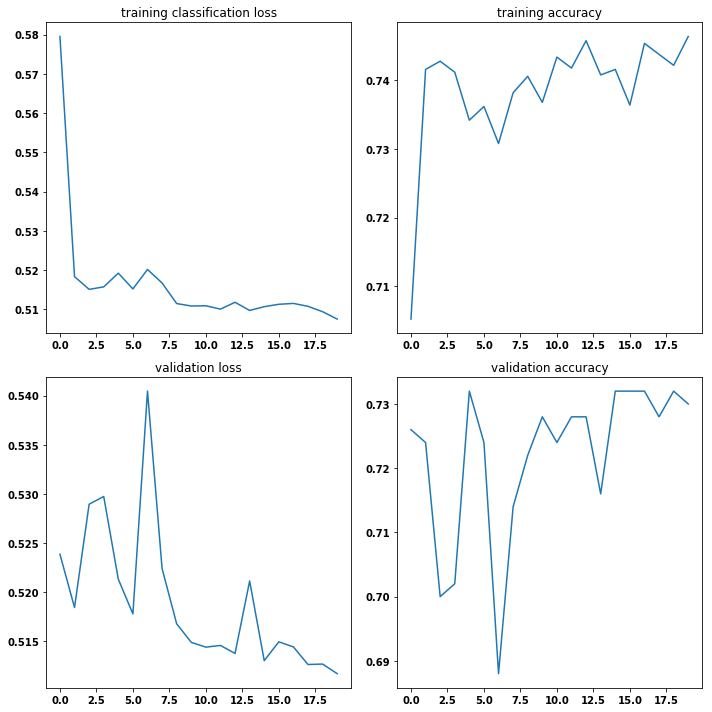

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)
# plt.legend()
plt.tight_layout()

In [16]:
test_loss, test_acc = validate_classifier_epoch(advtest_loader, laftr_encoder, classifier,
                                 adv_criterion, device)
test_loss, test_acc

/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/s1791387/miniconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [17]:
test_loss, test_acc

(0.5254635486602783, 0.718)